In [79]:
import import_ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import KFold

# Algorithme d'homotopie pour le LASSO

**Fonctions annexes**

In [80]:
def get_min_ind(liste):
    l = [x for x in liste if x > 1e-10]
    #l = [x for x in liste if np.any(x > tol)]
    if not l:
        return np.inf, 0
    min_value = np.min(l)
    min_index = np.where(liste == min_value)[0][0]
    if  min_value == 0:
        return np.inf, 0
    else:
        return min_value, min_index

def sum_Xi_coeffs(X_J, a_s_J):
    res = np.zeros(X_J.shape[0])
    for i in range(len(a_s_J)):
        res = res + X_J[:,i]*a_s_J[i]
    return res

def show_path(values, scale_log):
    lambdas = [l[0] for l in values]
    betas = np.vstack([b[1] for b in values])
    fig, ax = plt.subplots()
    ax.axhline(y=0, color='k', linestyle=':')
    ax.axvline(x=0, color='k', linestyle=':')
    if scale_log:
        ax.set_xscale('log')
    for i in range(betas.shape[1]):
        ax.plot(lambdas, [b[i] for b in betas])
    plt.xlabel('Lambda')
    plt.ylabel('Beta Coefficients')
    plt.title('LASSO Path')
    plt.show()

**Fonction principale**

In [81]:
def homo_lasso(X, y, k_max=1e3, prc = 99):
    start_time = time.time()
    n, p = X.shape
    L = np.arange(p)
    ### recuperation du signe du premier beta_i non nul au vosinage de np.linalg.norm(A, np.inf)
    A = (X.T)@y
    lam = np.linalg.norm(A, np.inf)
    norme_inf = lam
    beta_hat = np.zeros(p)
    j = np.argmax(np.abs(A))
    ### Pour garder les valeurs de lam et beta
    dtype = np.dtype([('nombre', np.float64), ('vecteur', np.float64, p)])
    values = np.empty(0, dtype=dtype)
    value = np.array([(lam, beta_hat)], dtype=dtype)
    values = np.append(values, value)
    ### MAJ de J et J_C
    J = np.array([j])   
    J_C = np.setdiff1d(L, J)
    s = np.zeros(p)
    s[j] = np.sign(A[j])
    s_J = [s[j] for j in J]
    l = 0
    lignes_a = [] 
    lignes_b = []
    while lam > 0 and k_max > l:
        l = l+1
        tau_pos_J_C = np.empty((0,))
        tau_neg_J_C = np.empty((0,))
        tau_J = np.empty((0,))
        X_J = X[:, J]
        X_J_T = X_J.T
        #inv_X_T_X = np.linalg.inv(X_J_T @ X_J)
        inv_X_T_X = np.linalg.solve(X_J_T @ X_J, np.eye(len(J)))
        ### calcul des pentes et des ordonnée à l'origine au voisinage inferieur de lambda
        a_s = np.zeros(p)
        b_s = np.zeros(p)
        if inv_X_T_X.shape[0] == 1:
            a_s_J = -inv_X_T_X * s_J
            b_s_J = inv_X_T_X * (X_J_T @ y)
        else:
            a_s_J = -inv_X_T_X @ s_J
            b_s_J = inv_X_T_X @ (X_J_T @ y)
        k = 0
        for i in range(p):
            if inv_X_T_X.shape[0] == 1:
                if i in J:
                    a_s[i] = a_s_J[0][k]
                    b_s[i] = b_s_J[k]
                    k = k+1
                else:
                    a_s[i] = 0
                    b_s[i] = 0
            else:
                if i in J:
                    a_s[i] = a_s_J[k]
                    b_s[i] = b_s_J[k]
                    k = k+1
                else:
                    a_s[i] = 0
                    b_s[i] = 0
        lignes_a.append(a_s)
        lignes_b.append(b_s)
        ###### calcul de tout les tau possibles
        ### Cas ou une composante nulle devient non-nulle
        for j in J_C:
            a = sum_Xi_coeffs(X_J, a_s_J)
            b = sum_Xi_coeffs(X_J, b_s_J)
            xa = np.dot(X[:,j], a)
            if (1+xa) == 0:
                tau_j_pos = np.inf
            else:
                tau_j_pos = lam + np.dot(X[:,j],(-y.T+b.T).T) / (1+xa)
            if (1-xa) == 0:
                tau_j_neg =np.inf
            else:
                tau_j_neg = lam + np.dot(X[:,j],(y.T-b.T).T) / (1-xa)
            tau_pos_J_C = np.append(tau_pos_J_C, tau_j_pos)
            tau_neg_J_C = np.append(tau_neg_J_C, tau_j_neg)
        tau_min_pos, ind_pos = get_min_ind(tau_pos_J_C)
        tau_min_neg, ind_neg = get_min_ind(tau_neg_J_C)
        ### Cas où une composante non-nulle devient nulle
        for j in J:
            if a_s[j] != 0:
                tau_j = lam + b_s[j] / a_s[j]
                tau_J = np.append(tau_J, tau_j)
            else:
                tau_J = np.append(tau_J, np.inf)
            #print("tau_j=", tau_j)

        tau_min, ind = get_min_ind(tau_J)
        ### selection du tau le plus petit /// mise a jour de J et J_C 
        if tau_min_pos <= tau_min_neg and tau_min_pos <= tau_min:
            #print("passe dans pos")
            lam = lam - tau_min_pos
            s[J_C[ind_pos]] = 1
            J = np.append(J, J_C[ind_pos])
            J = np.sort(J)
            J_C = np.setdiff1d(L, J)
            
        if tau_min_neg <= tau_min_pos and tau_min_neg <= tau_min:
            #print("passe dans neg")
            lam = lam - tau_min_neg
            s[J_C[ind_neg]] = -1
            J = np.append(J, J_C[ind_neg])
            J = np.sort(J)
            J_C = np.setdiff1d(L, J)
            
        if tau_min <= tau_min_neg and tau_min <= tau_min_pos:
            #print("passe dans autre")
            lam = lam - tau_min
            s[J[ind]] = 0
            index_remove = np.where(J == J[ind])[0][0]
            J = np.delete(J, index_remove)
            J_C = np.setdiff1d(L, J)
        s_J = [s[j] for j in J]
        ### calcul des valeurs de beta pour le nouveau lambda
        if lam < 1e-6: ### on continue dans la même direction jusqu'à lam=0
            lam = 0
            beta_hat = b_s
            value = np.array([(lam, beta_hat)], dtype=dtype)
            values = np.append(values, value)
            break
        else:
            beta_hat = a_s * lam + b_s
            value = np.array([(lam, beta_hat)], dtype=dtype)
            values = np.append(values, value)
    end_time = time.time()
    execution_time = end_time - start_time
    print(execution_time, "s")
    ### Matrices des pentes et ordonnées a l origine
    matrice_a_s = np.vstack(lignes_a)
    matrice_b_s = np.vstack(lignes_b)
    return values, matrice_a_s, matrice_b_s

Exemple pour le dataset `winequality`: $X \in \mathbb{R}^{1599 \times 11}$ et $Y \in \mathbb{R}^{1599}$\
Chaque colonne de $X$ représente des observation sur un vin telles que le pH, l'acidité,... Et $Y$ représente la qualité du vin sous forme d'une note de 1 à 10

In [82]:
### Importation et normalisation des données
file_path = 'winequality-red.csv'
data = pd.read_csv(file_path, sep=';', header=None)
y = data.iloc[:, -1].to_numpy()
X = data.iloc[:, :-1].to_numpy()
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
y_mean = np.mean(y)

X = (X - X_mean) / X_std
y = y - y_mean
n = X.shape[0]
p = X.shape[1]

# I. Minimisation somme des carrés résiduels

Calculons $\hat{\beta}(\lambda)$ sur un échantillon d'entrainement, puis minimisons $
\lambda > 0 \mapsto \|Y^{test}-X^{test} \hat{\beta}(\lambda)\|_{2}^{2}
$ sur un echantillon de test

In [38]:
train_size = int(X.shape[0] * 0.7)
train_indices = np.arange(train_size)
test_indices = np.arange(train_size, X.shape[0])

X_train = X[train_indices]
X_test = X[test_indices]
y_train = y[train_indices]
y_test = y[test_indices]

In [39]:
values_train, a_train, b_train = homo_lasso(X_train,y_train)

0.04150271415710449 s


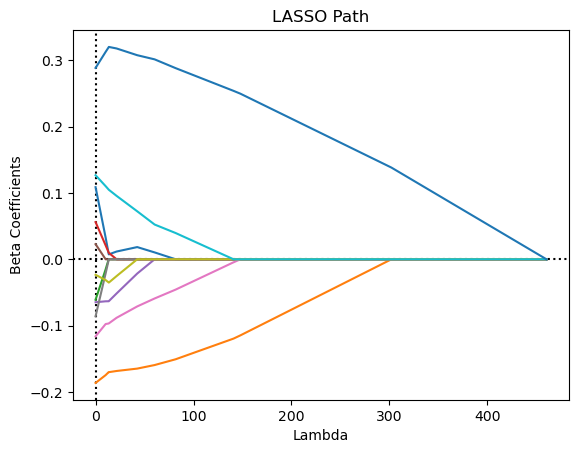

In [40]:
show_path(values_train, False)

On minimise :
$
\lambda > 0 \mapsto SCR(\lambda )=\|Y^{test}-X^{test} \hat{\beta}(\lambda)\|_{2}^{2}
$
afin de determiner $\lambda_{opt}$ (Fonction quadratique par morceaux)

In [41]:
lambdas_train = np.array([l[0] for l in values_train])
betas_train = np.vstack([b[1] for b in values_train])

minimum = 209.27232291129985, atteint en  lambda = 13.530961838851303


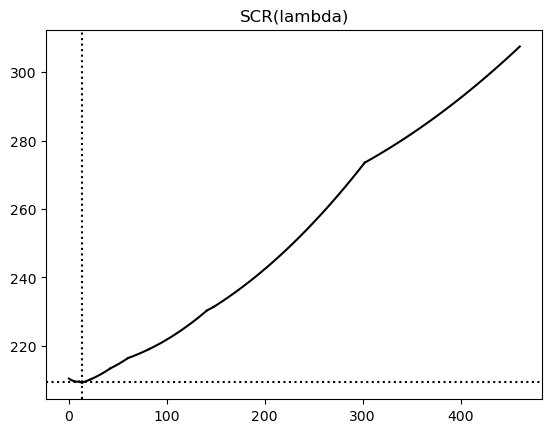

In [42]:
yTy = y_test.T @ y_test
min_values = np.empty((0,)) 
min_points = np.empty((0,))
for i in range(len(lambdas_train)-1):
#for i in range(len(lambdas_train)-50, len(lambdas_train)-20):
    plage = np.linspace(lambdas_train[i], lambdas_train[i+1], 100)
    v1 = X_test @ a_train[i,:]
    v2 = X_test @ b_train[i,:]
    norm_v1 = np.linalg.norm(v1)**2
    norm_v2 = np.linalg.norm(v2)**2
    yTv2 = y_test.T @ v2
    yTv1 = y_test.T @ v1
    v1Tv2 = v1.T @ v2
    ### coeff de la fonction quadratique
    a = norm_v1
    b = 2*v1Tv2 - 2*yTv1
    c = yTy + norm_v2 - 2*yTv2
    
    plt.plot(plage, a * plage**2 + b * plage + c, color='k')
    #plt.axvline(x=lambdas[i], linestyle=':')
    ### calcul du min sur chaque portion
    if a != 0:
        x_min = -b / (2 * a)
        if lambdas_train[i] >= x_min >= lambdas_train[i+1]:
            min_value = a * x_min**2 + b * x_min + c
            min_point = x_min
        else:
            f_g = a * lambdas_train[i]**2 + b * lambdas_train[i] + c
            f_d = a * lambdas_train[i+1]**2 + b * lambdas_train[i+1] + c
            if f_g < f_d:
                min_value = f_g
                min_point = lambdas_train[i]
            else:
                min_value = f_d
                min_point = lambdas_train[i+1]
    else:
        # Si a est 0, c'est une fonction linéaire ou constante
        f_g = b * lambdas_train[i] + c
        f_d = b * lambdas_train[i+1] + c
        if f_g < f_d:
            min_value = f_g
            min_point = lambdas_train[i]
        else:
            min_value = f_d
            min_point = lambdas_train[i+1]
    min_values = np.append(min_values, min_value)
    min_points = np.append(min_points, min_point)
### calcul du min et argmin(lam) sur l'union des portions
global_min_index = np.argmin(min_values)

global_min_value = min_values[global_min_index]
global_min_point = min_points[global_min_index]
print(f"minimum = {global_min_value}, atteint en  lambda = {global_min_point}")
plt.axvline(x=global_min_point, color='k', linestyle=':')
plt.title('SCR(lambda)')
plt.axhline(y=global_min_value, color='k', linestyle=':')

Après avoir déterminé $\lambda_{opt}$, on détermine $\hat{\beta}(\lambda_{opt})$ via le chemin des solutions calculé sur toutes les données

In [43]:
values_train, a_train, b_train = homo_lasso(X_train,y_train)
lambdas_train = np.array([l[0] for l in values_train])
betas_train = np.vstack([b[1] for b in values_train])

0.01999950408935547 s


In [44]:
for i in range(len(lambdas_train)):
    if lambdas_train[i] <= global_min_point:
        coef_a = a_train[i]
        coef_b = b_train[i]
        break
beta_opt_SCR = coef_a*global_min_point + coef_b
print("lambda optimal = ", global_min_point)
print("variables sélectionnées ---->", 11-np.sum(beta_opt_SCR == 0), "sur 11")

lambda optimal =  13.530961838851303
variables sélectionnées ----> 9 sur 11


Autrement dit, $\|\hat{\beta}(\lambda_{opt,SCR})\|_0=9$

# II. Validation croisée (K-folds)
Une autre approche pour selectionner $\lambda_{opt}$, est la **validation croisée**.
On opte pour la validation croisée **K-folds**\
**Principe de la validation croisée:**(K-folds)  Pour $X\in \mathbb{R}^{n \times p}$ et $Y\in \mathbb{R}^{n}$

- On divise l'ensemble $\left\{1, \dots,n \right\}$ en $K$ sous-ensembles $F_1,\dots,F_K$ de tailles à peu près égales.
- Pour $k=1,\dots,K$
    - On calcul $\lambda >0 \mapsto \beta(\lambda)$ sur $\left[X_i \right]_{i\notin F_k}$ où $X_i$ est la i-ème ligne de $X$, et $\left[Y_i \right]_{i\notin F_k}$ où $Y_i$ est la i-ème composante de $Y$
    - On calcul $\epsilon_k(\lambda) = \sum_{i\in F_k} (Y_i - X_i \hat{\beta}(\lambda))^2$
- Enfin, on minimise $CV(\lambda) = \frac{1}{n} \sum_{k=1}^{K} \epsilon_k(\lambda) = \frac{1}{n} \sum_{k=1}^{K} \sum_{i\in F_k} (Y_i - X_i \hat{\beta}(\lambda))^2$ pour obtenir $\lambda_{opt}$ puis $\beta(\lambda_{opt})$

In [45]:
kf = KFold(n_splits=5, shuffle=False)#, random_state=42)
norm_max = 45
lam_values = np.linspace(norm_max, 0.01, 200)
error = np.zeros(len(lam_values)) 
k=0
for train_index, test_index in kf.split(X):
    k+=1
    X_train = X[train_index] 
    X_test =  X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    values_train1, a_train1, b_train1 = homo_lasso(X_train,y_train)
    lambdas_train1 = np.array([l[0] for l in values_train1])
    betas_train1 = np.vstack([b[1] for b in values_train1])
    
    ### on recupere les valeurs de beta pour la liste lam_values
    list_beta = np.zeros((len(lam_values),11)) 
    for index,k in enumerate(lam_values):
        if k >= np.linalg.norm(X_train.T @ y_train, np.inf):
            list_beta[index, :] = np.zeros(11)
        else:
            for i in range(len(lambdas_train1)-1):
                if lambdas_train1[i] <= k:
                    coef_a1 = a_train1[i]
                    coef_b1 = b_train1[i]
                    break
            list_beta[index, :] = coef_a1 * k + coef_b1
    subsum = np.zeros(len(lam_values))
    for i,b in enumerate(list_beta):
        for j in test_index:
            subsum[i] += (y[j] - np.dot(X[j,:], b))**2
    error += subsum

0.014998912811279297 s
0.012000083923339844 s
0.01098942756652832 s
0.01199793815612793 s
0.01598501205444336 s


lambda optimal ----> 11.087939698492463


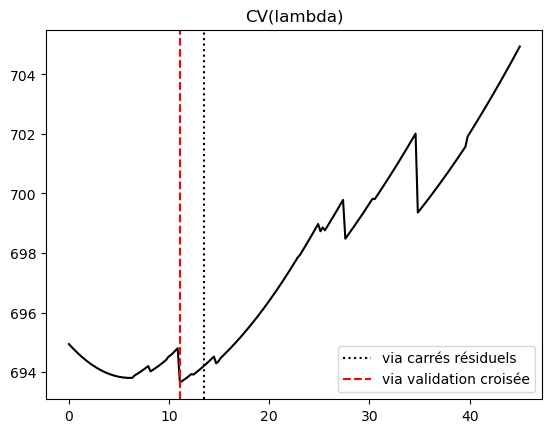

In [46]:
argmin = np.argmin(error)
mini = np.min(error)
plt.plot(lam_values, error, color='k')
plt.axvline(x=global_min_point, color='k', linestyle=':', label='via carrés résiduels')
plt.axvline(x=lam_values[argmin], color='r', linestyle='--', label='via validation croisée')
plt.title('CV(lambda)')
plt.legend()
print("lambda optimal ---->",lam_values[argmin])

On a donc $\lambda_{opt}$. On calcule $\hat{\beta}(\lambda_{opt})$ via le chemin des solutions sur toutes les données.

In [47]:
values, a, b = homo_lasso(X,y)
lambdas = np.array([l[0] for l in values])
betas = np.vstack([b[1] for b in values])

0.023001432418823242 s


In [48]:
for i in range(len(lambdas)):
    if lambdas[i] <= lam_values[argmin]:
        coef_a_CV = a[i]
        coef_b_CV = b[i]
        break
beta_opt_CV = coef_a_CV*lam_values[argmin] + coef_b_CV
print("lambda =", lam_values[argmin])
print("variables sélectionnées CV ---->", 11-np.sum(beta_opt_CV == 0), "sur 11")

lambda = 11.087939698492463
variables sélectionnées CV ----> 10 sur 11


Autrement dit, $\|\hat{\beta}(\lambda_{opt, CV
})\|_0=10$

In [59]:
file_path = 'winequality-red.csv'
data = pd.read_csv(file_path, sep=';', header=None)
y = data.iloc[:, -1].to_numpy()
yb = data.iloc[:, -1].to_numpy()
X = data.iloc[:, :-1].to_numpy()
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
y_mean = np.mean(y)

X = (X - X_mean) / X_std
y = y - y_mean
n = X.shape[0]
p = X.shape[1]

values, amat, bmat = homo_lasso(X,y)
#show_path(values, False)
lambdas = np.array([l[0] for l in values])
betas = np.vstack([b[1] for b in values])

0.024997949600219727 s


# III. Formule SURE (Stein Unbiaised Risk Estimator)
La formule SURE est un estimateur sans biais de l'erreur quadratique moyenne.\
$SURE(\lambda)=\|Y-X\hat{\beta}(\lambda)\|_2^2 -n\sigma^2+2\sigma^2\|\hat{\beta}(\lambda)\|_0$ (Fonction quadratique par morceaux mais pas continue)\
Où $\sigma^2$ est la variance des résidus.\
Dans la formule SURE, on remplace $\sigma^2$ par un estimateur : 
$$
\hat{\sigma^2}= \frac{1}{1588} \|\left(I_n - X(X^\top X)^{-1}X^\top\right)Y\|_2^2
$$

minimum = 3.29040798201231, atteint en  lambda = 11.760166479819352


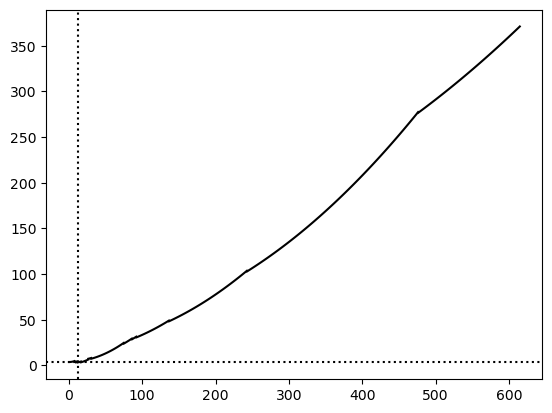

In [60]:
yTy = y.T @ y
sig_squared = (1/(n-p))*np.linalg.norm((np.identity(n) - X @ np.linalg.inv(X.T @ X) @ X.T) @ y)**2
min_values = np.empty((0,))
min_points = np.empty((0,))
for i in range(len(lambdas)-1):
#for i in range(len(lambdas_train)-7, len(lambdas_train)-1):
    plage = np.linspace(lambdas[i], lambdas[i+1], 100)
    v1 = X @ amat[i,:]
    v2 = X @ bmat[i,:]
    norm_v1 = np.linalg.norm(v1)**2
    norm_v2 = np.linalg.norm(v2)**2
    yTv2 = y.T @ v2
    yTv1 = y.T @ v1
    v1Tv2 = v1.T @ v2
    ### coeff de la fonction quadratique
    a = norm_v1
    b = 2*v1Tv2 - 2*yTv1
    c = yTy + norm_v2 - 2*yTv2 - n*sig_squared + 2*sig_squared*np.count_nonzero(betas[i])
    
    plt.plot(plage, a * plage**2 + b * plage + c, color='k')
    #plt.axvline(x=lambdas[i], linestyle=':')
    ### calcul du min sur chaque portion
    if a != 0:
        x_min = -b / (2 * a)
        if lambdas[i] >= x_min >= lambdas[i+1]:
            min_value = a * x_min**2 + b * x_min + c
            min_point = x_min
        else:
            f_g = a * lambdas[i]**2 + b * lambdas[i] + c
            f_d = a * lambdas[i+1]**2 + b * lambdas[i+1] + c
            if f_g < f_d:
                min_value = f_g
                min_point = lambdas[i]
            else:
                min_value = f_d
                min_point = lambdas[i+1]
    else:
        # Si a est 0, c'est une fonction linéaire ou constante
        f_g = b * lambdas[i] + c
        f_d = b * lambdas[i+1] + c
        if f_g < f_d:
            min_value = f_g
            min_point = lambdas[i]
        else:
            min_value = f_d
            min_point = lambdas[i+1]
    min_values = np.append(min_values, min_value)
    min_points = np.append(min_points, min_point)
### calcul du min et argmin(lam) sur l'union des portions
global_min_index = np.argmin(min_values)

global_min_value = min_values[global_min_index]
global_min_point = min_points[global_min_index]
print(f"minimum = {global_min_value}, atteint en  lambda = {global_min_point}")
plt.axvline(x=global_min_point, color='k', linestyle=':')
plt.axhline(y=global_min_value, color='k', linestyle=':')

Calcul de la valeur optimale pour le vecteur des paramètres $\hat{\beta}$

In [61]:
for i in range(len(lambdas)):
    if lambdas[i] <= global_min_point:
        coef_a_SURE = amat[i]
        coef_b_SURE = bmat[i]
        break
beta_opt_SURE = coef_a_SURE*global_min_point + coef_b_SURE
print("lambda =", global_min_point)
print("variables sélectionnées SURE ---->", 11-np.sum(beta_opt_SURE == 0), "sur 11")

lambda = 11.760166479819352
variables sélectionnées SURE ----> 9 sur 11


Autrement dit, $\|\hat{\beta}(\lambda_{opt, SURE})\|_0=9$

# IV. Conclusion

- **SCR**  : $\lambda_{opt}=13.530961838851303$ ---> nombre de variables selectionnnées : 9
- **SURE** : $\lambda_{opt}=11.760166479819352$ ---> nombre de variables selectionnnées : 9
- **CV**   : $\lambda_{opt}=11.087939698492463$ ---> nombre de variables selectionnnées : 10

In [62]:
indices_non_nuls_CV = np.nonzero(beta_opt_CV)[0]
indices_non_nuls_SCR = np.nonzero(beta_opt_SCR)[0]
indices_non_nuls_SURE = np.nonzero(beta_opt_SURE)[0]
print("SCR--->",indices_non_nuls_SCR)
print("SURE--->",indices_non_nuls_SURE)
print("CV--->",indices_non_nuls_CV)
z = list(set(indices_non_nuls_CV) & set(indices_non_nuls_SCR) & set(indices_non_nuls_SURE))
print("Nombre de variables selectionnées par les trois méthodes ---->",len(z))

SCR---> [ 0  1  3  4  6  7  8  9 10]
SURE---> [ 1  2  3  4  5  6  8  9 10]
CV---> [ 0  1  2  3  4  5  6  8  9 10]
Nombre de variables selectionnées par les trois méthodes ----> 7


**Calculons l'erreur pour chaque méthode de sélection de $\lambda_{opt}$**

1. $\sum_{i=1}^{1599}\left\lvert\left[Y-X\hat{\beta}(\lambda_{opt})\right]_i\right\rvert$

In [85]:
err_sure_abs = abs(y-X@beta_opt_SURE)
print("SURE --->",np.sum(err_sure_abs))
err_cv_abs = abs(y-X@beta_opt_CV)
print("CV --->",np.sum(err_cv_abs))
err_scr_abs = abs(y-X@beta_opt_SCR)
print("SCR --->",np.sum(err_scr_abs))

SURE ---> 804.2092311929796
CV ---> 803.9649121384568
SCR ---> 806.7252387167129


2. $\|Y-X\hat{\beta}(\lambda_{opt})\|_2^2$

In [75]:
err_sure_sqr = np.linalg.norm(y-X@beta_opt_SURE)**2
err_cv_sqr = np.linalg.norm(y-X@beta_opt_CV)**2
err_scr_sqr = np.linalg.norm(y-X@beta_opt_SCR)**2
print("SURE --->", err_sure_sqr)
print("CV --->", err_cv_sqr)
print("SCR --->", err_scr_sqr)

SURE ---> 668.4421460887161
CV ---> 668.3017045257075
SCR ---> 676.0604162160776


Pour ce dataset, la méthode de validation croisée semble être la meilleure. Bien que la méthode SURE ait une erreur presque équivalente.